Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

Loading the dataset to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset=os.listdir('/content/drive/MyDrive/Data/train')
test_dataset=os.listdir('/content/drive/MyDrive/Data/test')
valid_dataset=os.listdir('/content/drive/MyDrive/Data/valid')
train_dataset_path="/content/drive/MyDrive/Data/train"
test_dataset_path="/content/drive/MyDrive/Data/test"
valid_dataset_path="/content/drive/MyDrive/Data/valid"

In [ ]:
print(train_dataset)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'normal']


In [ ]:
print(test_dataset)

['normal', 'squamous.cell.carcinoma', 'large.cell.carcinoma', 'adenocarcinoma']


Labelling the dataset

In [ ]:
xtrain_label_path=[]
xtest_label_path=[]

trainlabel={'normal':0, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib':1, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa':2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa':3}
testlabel={'normal':0, 'squamous.cell.carcinoma':3, 'adenocarcinoma':1, 'large.cell.carcinoma':2}

ytrain_label=[]
ytest_label=[]

for path in train_dataset:
  c=path
  p= os.path.join(train_dataset_path,path)
  # print(p)
  for i in os.listdir(p):
    pt = os.path.join(p+"/"+i)
    xtrain_label_path.append(pt)
    ytrain_label.append(trainlabel[c])

for path in valid_dataset:
  c=path
  p= os.path.join(valid_dataset_path,path)
  for i in os.listdir(p):
    pt = os.path.join(p+"/"+i)
    xtrain_label_path.append(pt)
    ytrain_label.append(trainlabel[c])

for path in test_dataset:
  c=path
  p= os.path.join(test_dataset_path,path)
  for i in os.listdir(p):
    pt = os.path.join(p+"/"+i)
    xtest_label_path.append(pt)
    ytest_label.append(testlabel[c])

Feature Extraction using VGG16

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

X_images = xtrain_label_path
y = ytrain_label

# Preprocess images for VGG16
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Extracting features using VGG16
X_features = []
for img_path in X_images:
    img_array = preprocess_image(img_path)
    features = base_model.predict(img_array)
    X_features.append(features.flatten())

X_features = np.array(X_features)
y = np.array(y)

# Spliting the dataset to training and testing training-80% testing-20%
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

1/1 [==============================] - 0s 26ms/step
(548, 25088)
(137, 25088)
(548,)
(137,)


XGBoost Classifier

In [ ]:
#Load the XGB classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)

#Fit the model with the feature extracted data from vgg16
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

Results

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# print(accuracy)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9124087591240876


In [ ]:
from sklearn import metrics
report = metrics.classification_report(y_test, y_pred, target_names=test_dataset)
print(report)


                         precision    recall  f1-score   support

                 normal       0.96      0.96      0.96        28
squamous.cell.carcinoma       0.90      0.88      0.89        50
   large.cell.carcinoma       0.93      0.93      0.93        30
         adenocarcinoma       0.87      0.90      0.88        29

               accuracy                           0.91       137
              macro avg       0.92      0.92      0.92       137
           weighted avg       0.91      0.91      0.91       137



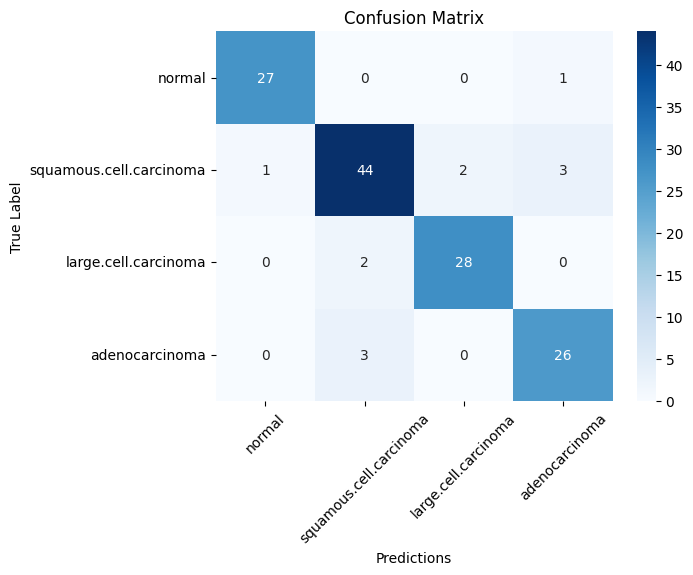

In [ ]:
#Visualising results using coefficient matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset, yticklabels=test_dataset)
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.xticks(rotation = 45)
plt.show()